# A DCGAN implementation with KERAS

This notebook contains my own implementation of a Deep-Convolutional-Generative-Adversarial-Netwoork (DCGAN). The goal of this algorithm is to generate hadwritten characters by training on the MNIST dataset.

## Gathering the MNIST dataset

The MNIST dataset is part of the Keras package, which I will use to implement the DCGAN. It can be imported into the project as follows:

In [46]:
from keras.datasets import mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

By means of the instructions above, I have defined train and test samples for my project. Let see at the shape of the numpy arrays I have created:

In [91]:
#Xtrain /= 255
#Xtest /= 255

Xtrain = (Xtrain - 127.5) / 127.5
Xtest = (Xtest - 127.5) / 127.5
Xtrain.shape

(60000, 28, 28, 1)

The dataset contains 60000 images with 28x28 pixels. Let's visualize the first 100 examples:

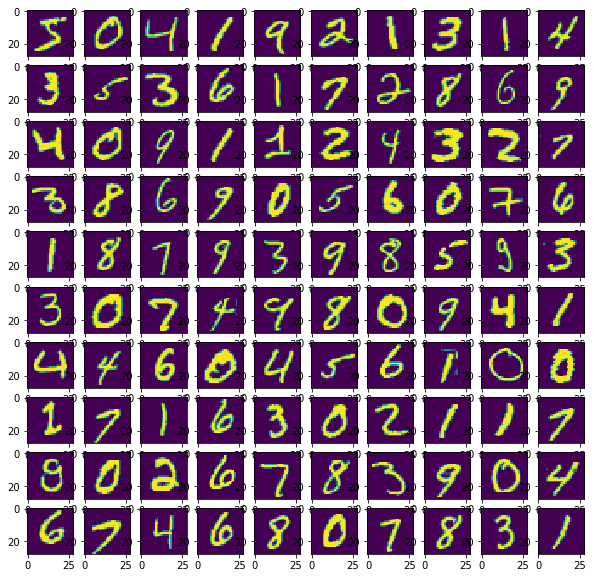

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(10,10,figsize=(10,10))
ind=0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(Xtrain[ind,:,:])
        ind+=1

We can also give a look at the corresponding labels:

In [49]:
Ytrain[:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9,
       1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9,
       8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0,
       0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7,
       4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

As the keras Conv2D layer expects 4D tensor as input, I will reshape the training and the test set accordingly:

In [50]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1)

Xtrain = Xtrain.astype('float32')

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
#Xtrain = (Xtrain - 127.5) / 127.5

#X_train.shape

## The Generator

Let's assume $p(z)$ is a simple, well-known distribution, e.g. a uniform distribution between -1 and 1. We represent sampling a number from this distribution as $z\sim p(z)$. I will use this distribution to generate images through a generator model $G(z)$. 

The generator is a deep convolutional neural network. Given the choice for $p(z)$, the input layer is a vector on $N$ random numbers. 


In [51]:
import numpy as np
N=100

def samplePZ(batch_size=1):
    z = np.random.uniform(-1, 1, [batch_size,N])
    return(z)

z=samplePZ()
z[0,:]

array([ 0.34912423, -0.40976   ,  0.84507326,  0.04187854,  0.93734919,
       -0.54138051,  0.43819353,  0.45120689,  0.77548731, -0.43647813,
        0.05390716, -0.65043453, -0.48059605, -0.1973282 , -0.26556101,
       -0.28758434,  0.17417036,  0.53675759, -0.62232151,  0.0935046 ,
        0.32556791, -0.09804208,  0.72438223, -0.5622544 ,  0.98705523,
       -0.40124086, -0.50610971, -0.73235129, -0.88406063,  0.81185358,
       -0.39639249,  0.5567959 ,  0.40407039, -0.01825021,  0.95528572,
        0.50701852, -0.59668667, -0.68695124,  0.40741752, -0.41918704,
        0.51369469, -0.73459809,  0.85092944, -0.72761836, -0.34752733,
       -0.22673496, -0.65052485,  0.69008266, -0.32634005,  0.31559607,
       -0.62956665,  0.029547  ,  0.41697031, -0.21573973,  0.06902354,
        0.25547281,  0.97621104,  0.19019164,  0.78956279,  0.57419434,
       -0.91211017, -0.34752172, -0.61368899, -0.11043115, -0.9849023 ,
       -0.66437768,  0.38507227, -0.81307015, -0.09415903,  0.67

I use keras to build the network. The architecture will be:
* an (dense) input layer
* a sequence of fractionally-strided (de-)convolutions
* batch-normalization layers to normalize the input to each activation function, so that we are centered in the linear section of the activation function
* between each layer and the next, I will upscale the images by a factor 2, and reduce the depth of the convolution layer by the same factor


In [52]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

depth=128
dim=int(Xtrain.shape[1]/4)
dropout = 0.4

def generator(input_dim=100,dim=7,depth=128,droput=0.4,ch=3,momentum=0.9,lrelu=0.2):
    G=Sequential()
    # Input layer [1,100]
    G.add(Dense(dim*dim*depth, input_dim=input_dim))
    G.add(BatchNormalization())
    G.add(Activation(LeakyReLU(lrelu)))
    G.add(Reshape((dim, dim, depth)))
    G.add(Dropout(dropout)) #setting a fraction rate of input units to 0 at each update during training time, 
                            #which helps prevent overfitting.
    
    # 1st convolutional layer: input [dim,dim,depth], output [2*dim, 2*dim, depth/2]
    G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    G.add(BatchNormalization(momentum=momentum))
    G.add(Activation(LeakyReLU(lrelu)))
    G.add(UpSampling2D())
    
    # 2nd convolutional layer: input [2*dim,2*dim,depth/2], output [4*dim, 4*dim, depth/4]
    
    G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    G.add(BatchNormalization(momentum=momentum))
    G.add(Activation(LeakyReLU(lrelu)))
    G.add(UpSampling2D())
    
    # 3rd convolutional layer: input [4*dim,4*dim,depth/4], output [4*dim, 4*dim, depth/8]
    G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation(LeakyReLU(0.2)))
    
    # output layer (1,4*dim,4*dim,ch)
    G.add(Conv2DTranspose(ch, 5, padding='same'))
    G.add(Activation('tanh'))
    G.summary()
    
    return(G)
    
G=generator() 
G.compile(loss='binary_crossentropy', optimizer=Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_20 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_28 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 7, 7, 64)          204864    
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 7, 64)          256       
__________

We can now give a look at how the output of the generator looks like. By default, the generator outputs a image 3 channels (RGB):

-0.0919694 0.0842234


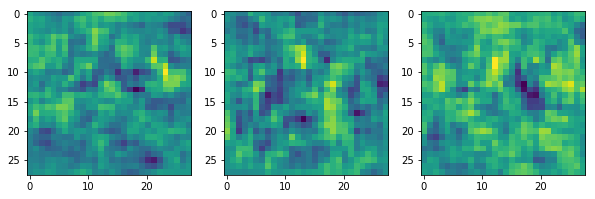

In [53]:
img=G.predict(z)
fig,ax=plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img[0,:,:,0])
ax[1].imshow(img[0,:,:,1])
ax[2].imshow(img[0,:,:,2])
print np.min(img),np.max(img)

As we can see, this is pure noise! 

We actually don't need to generate RGB images, as the MNIST examples are gray-scale images. We can build the generator using the ```ch=1``` flag then:

In [54]:
G=generator(ch=1) 
G.compile(loss='binary_crossentropy', optimizer=Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 6272)              633472    
_________________________________________________________________
batch_normalization_24 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_33 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 7, 7, 64)          204864    
_________________________________________________________________
batch_normalization_25 (Batc (None, 7, 7, 64)          256       
__________

By acting on the ```batch_size``` flag of ```samplePZ```, I can change the dimensionality of the inputs to the generator.

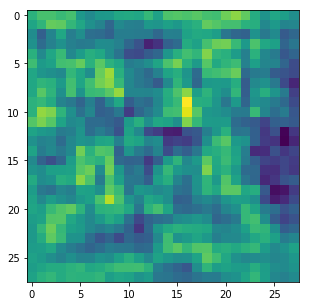

In [74]:
z=samplePZ(batch_size=1)
img=G.predict(z)
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.imshow(img[0,:,:,0])

Note that the pixel values in the output image are close to 0. This is the result of using the ```tanh``` activation function in the last layer of the generator.

In [75]:
print img.min(),img.max()

-0.108821 0.0785359


## Discriminator

The discriminator will be built as a standard convolutional neural network. The architecture will be:
* an input layer, expecting tensors with dimension (ch,Xtrain.shape[1],Xtrain.shape[2],1)
* other convolutional layers. I will increase the depth of the layer by a factor of two at each step, while reducing by the same factor the dimensions on both axes.
* the output layer is a dense layer which outputs a one-dimensional probability (of being the image real)
* at each layer a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting

As discussed [here](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/), the formula for calculating the output size for any given convolutional layer is 
$$
O=\frac{(W-K+2P)}{S}+1 \;,
$$
where $O$ is the output height/length, $W$ is the input height/length, $K$ is the filter size, $P$ is the padding, and $S$ is the stride. I use $K=5$. As for padding, I set ```padding='same'``` in the definition of the ```conv2D``` alyers in keras. This means that I zero-pad such that the  size of the output of the layer is equal to the size of input.


In [76]:
def discriminator(depth=64,dropout=0.4,ishape=(28,28,3)):
    D = Sequential()
    # 1st layer: in [ishape], out [14,14,128]
    D.add(Conv2D(depth, 5, strides=2, input_shape=ishape,\
            padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))
    # 2nd layer: [14,14,128], out [28,28,256]
    D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))
    # 3rd layer
    D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))
    # 4th layer
    D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))
    
    D.add(Flatten())
    D.add(Dense(1))
    D.add(Activation('tanh'))
    D.summary()
    return D

D=discriminator(ishape=(28,28,1))
D.compile(loss='binary_crossentropy', optimizer=Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)         819456    
__________

We can verify that the discriminator works when applied to an image:

In [77]:
print img.shape
res=D.predict(img)
res

(1, 28, 28, 1)


array([[-0.00015315]], dtype=float32)

## The adversarial model

Having defined the architectures of both the generator and discriminator networks, I can moove on and build an adversarial model. This is just another sequential model, where the input layer is the generator and the output layer is the discriminator.

In [60]:
def adversarial():
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    AD = Sequential()
    AD.add(generator())
    AD.add(discriminator())
    AD.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
    return AD

AD=adversarial()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 6272)              633472    
_________________________________________________________________
batch_normalization_28 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_39 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 7, 7, 64)          204864    
_________________________________________________________________
batch_normalization_29 (Batc (None, 7, 7, 64)          256       
__________

## Pre-training phase

I have now created:
* an untrained generator, which creates fake images
* a discriminator which can be trained to recognize the images from the true dataset (in this case the MNIST dataset)

This procedure (training the discriminator to distinguish between the fake and the true images) is called "pre-training". I believe it can speed-up the DCGAN considerably.

I will start creating a sample of fake images that I will use for the pre-training of the discriminator:

In [83]:
nbatches=10
img=[]
for i in range(nbatches):
    z=samplePZ(batch_size=200)
    img.append(G.predict(z))

img=np.array(img)
img=img.reshape(img.shape[1]*img.shape[0],img.shape[2],img.shape[3],img.shape[4])
img.shape


(2000, 28, 28, 1)

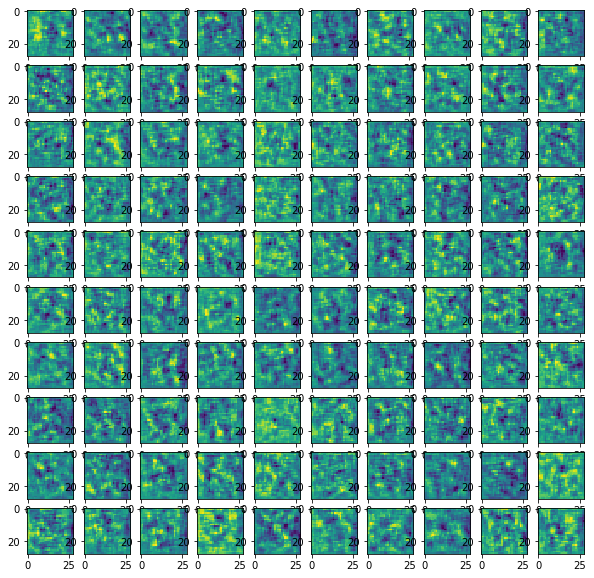

In [62]:
fig,ax=plt.subplots(10,10,figsize=(10,10))
ind=0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(img[ind,:,:,0])
        ind+=1

Now I can train the discriminator:

In [90]:
from tqdm import tqdm
batch_size=128
epoch=1
batch_count = Xtrain.shape[0] // batch_size
for i in range(epoch):
    for j in tqdm(range(batch_count)):
        noise_input = np.random.rand(batch_size, 100)
        image_batch = Xtrain[np.random.randint(0, Xtrain.shape[0], size=batch_size)]
        predictions = G.predict(noise_input, batch_size=batch_size)
        X = np.concatenate([predictions, image_batch])
        y_discriminator = [0]*batch_size + [1]*batch_size
        D.trainable = True
        D.train_on_batch(X, y_discriminator)

100%|██████████| 468/468 [25:27<00:00,  3.11s/it]


In [94]:
nbatches=10
img=[]
for i in range(nbatches):
    z=samplePZ(batch_size=200)
    img.append(G.predict(z))

img=np.array(img)
img=img.reshape(img.shape[1]*img.shape[0],img.shape[2],img.shape[3],img.shape[4])
img.shape

x_temp=Xtest[:1000,:,:,:]

x_test = np.concatenate((x_temp, img))
y_test=D.predict(x_test)

(array([ 2000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1000.]),
 array([ -9.99988139e-01,  -7.99989325e-01,  -5.99990511e-01,
         -3.99991697e-01,  -1.99992883e-01,   5.93066216e-06,
          2.00004745e-01,   4.00003558e-01,   6.00002372e-01,
          8.00001186e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

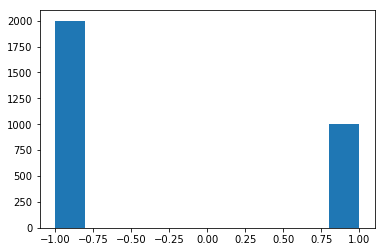

In [95]:
plt.hist(y_test)

## Training the GAN

Training the GAN involves the following steps:

* Train D using batches of MNIST images and images generated with G from random noise
* Train AD after setting D as untrainable. This means we train G to produce images trying to maximize the rate at which D will classify them as true.
* When doing so, we will set the label of the generated images to "True". The loss function of AD is the difference between these labels and the Discriminator prediction.
* repeat



In [98]:
batch_size=128
epoch=5
batch_count = Xtrain.shape[0] // batch_size
for i in range(epoch):
    for j in tqdm(range(batch_count)):
        # the first part of the look is identical to training D
        noise_input = np.random.rand(batch_size, 100)
        image_batch = Xtrain[np.random.randint(0, Xtrain.shape[0], size=batch_size)]
        predictions = G.predict(noise_input, batch_size=batch_size)
        X = np.concatenate([predictions, image_batch])
        y_discriminator = [0]*batch_size + [1]*batch_size
        D.trainable = True
        D.train_on_batch(X, y_discriminator)
        # now we set the Discriminator as untrainable and we generate mock images trying to maximize the rate 
        # of images that the discriminator classifies as false.
        # Note that, at each step, the discriminator is updated (as shown in the previous lines)
        noise_input = np.random.rand(batch_size, 100)
        # set labels of generated images 
        y_generator = [1]*batch_size
        D.trainable = False
        # train the adversarial model
        AD.train_on_batch(noise_input, y_generator)

100%|██████████| 468/468 [42:53<00:00,  6.38s/it]


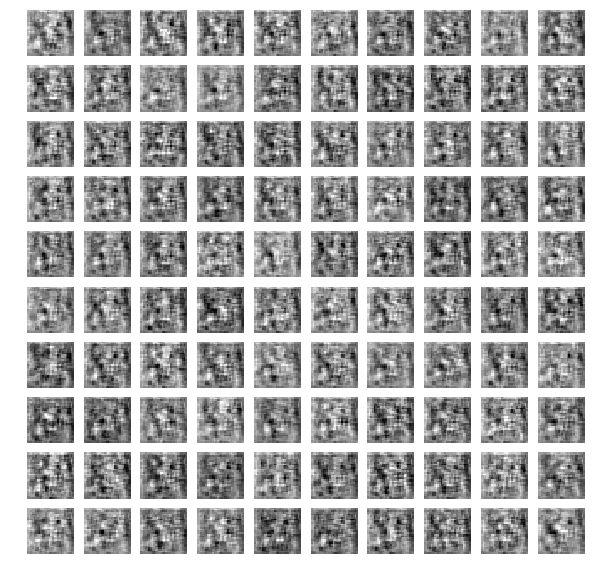

In [100]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = G.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    #plt.tight_layout()
    
plot_output()